In [2]:
import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
train_transform=transforms.Compose([
    transforms.RandomResizedCrop((227,227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
test_transform=transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [4]:
train_data=datasets.CIFAR10(root='./data',train=True,download=True,transform=train_transform)
test_data=datasets.CIFAR10(root='./data',train=False,download=True,transform=test_transform)

In [5]:
trainloader=DataLoader(train_data,batch_size=32,shuffle=True)
testloader=DataLoader(test_data,batch_size=1000,shuffle=False)

In [17]:
def visualise(trainloader):
    images,labels=next(iter(trainloader))
    images,labels=images.to(torch.device("cpu")),labels.to(torch.device("cpu"))
    classes=trainloader.dataset.classes
    fig,axes=plt.subplots(1,5,figsize=(20,3))
    for i in range(5):
        im=images[i].cpu().numpy().transpose((1,2,0))
        mean=np.array([0.485, 0.456, 0.406])
        sd=np.array([0.229, 0.224, 0.225])
        im=sd*im+mean
        im=np.clip(im,0,1)
        axes[i].set_title(f"Label : {classes[labels[i].item()]}")
        axes[i].imshow(im)
    plt.show()

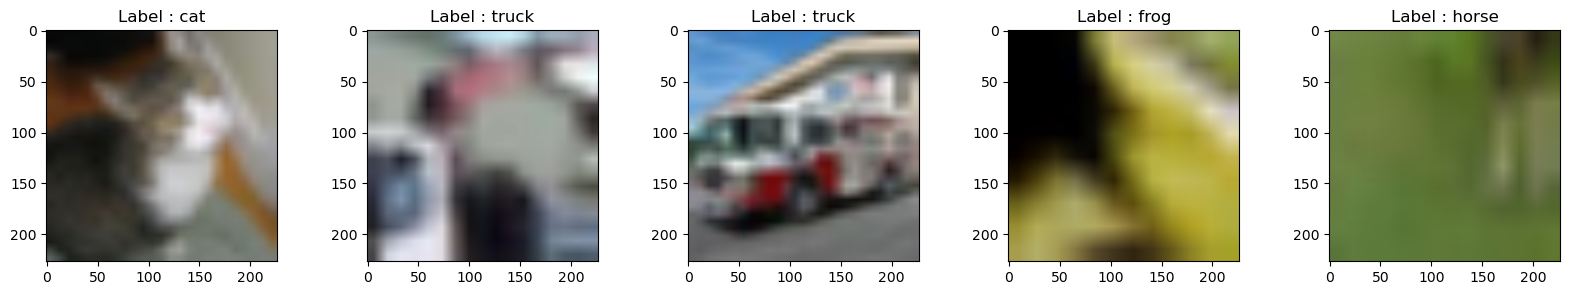

In [18]:
visualise(trainloader)

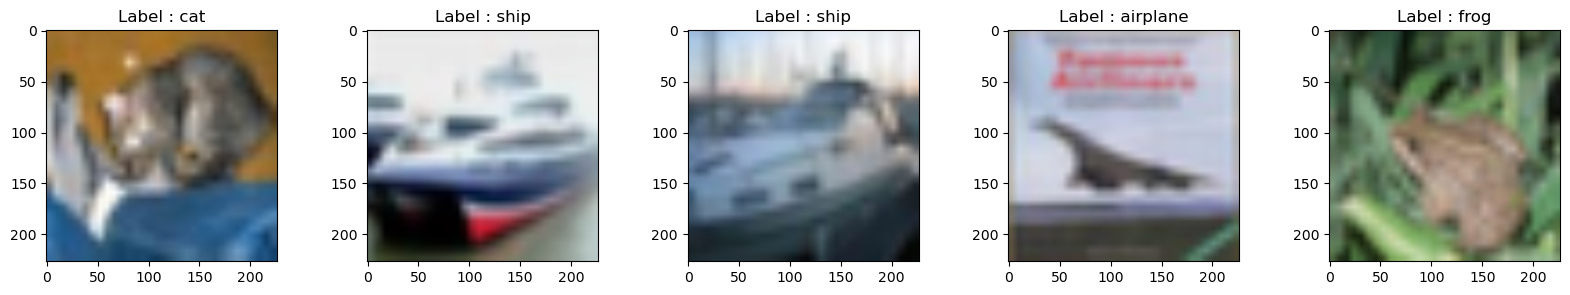

In [19]:
visualise(testloader)

In [32]:
import torch
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1)
        return x

class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.extractor = FeatureExtractor()
        self.classifier = Classifier(num_classes)

    def forward(self, x):
        x = self.extractor(x)
        x = self.classifier(x)
        return x


In [33]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AlexNet().to(device)
print(model)

AlexNet(
  (extractor): FeatureExtractor(
    (layers): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Classifier(
    (layers): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=9216, out

In [ ]:
def train(model,device,trainloader,optimizer,epochs):
    model.train()
    for epoch in epochs:
        for batch_idx , (images,labels) in enumerate(trainloader):
            images,labels=images.to(device),labels.to(device)
            optimizer.zero_grad()
            output=model(images)
            loss=F.cross_entropy(output,labels)
            loss.backward()
            optimizer.step()
            